**Loading file and librairies**

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import os

#### Sanity check: Look at response function profile on 2010-05-06, the day of the historic flash crash, for the AAPL asset

In [41]:
# Read the Parquet file
AAPL = pl.read_parquet("processed/final_yearly/AAPL.OQ_combined.parquet")

AAPL.head()

index,xltime,bid-price,bid-volume,ask-price,ask-volume,trade-price,trade-volume,date
str,f64,f64,i64,f64,i64,f64,i64,str
"""2010-01-04T09:30:00.001000""",40182.604167,213.32,1,213.42,1,null,null,"""2010-01-04"""
"""2010-01-04T09:30:00.009000""",40182.604167,213.37,1,213.5,3,null,null,"""2010-01-04"""
"""2010-01-04T09:30:00.020000""",40182.604167,213.38,2,213.5,1,null,null,"""2010-01-04"""
"""2010-01-04T09:30:00.042000""",40182.604167,213.39,1,213.5,1,null,null,"""2010-01-04"""
"""2010-01-04T09:30:00.087999""",40182.604168,213.4,1,213.5,1,null,null,"""2010-01-04"""


##### Computing and plotting the response function

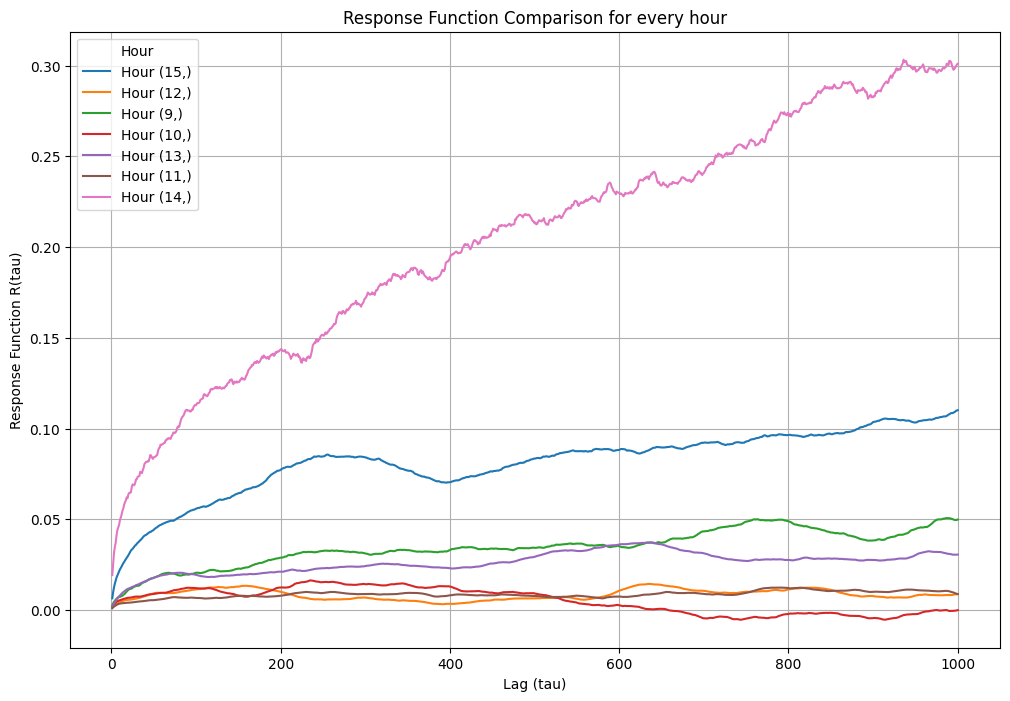

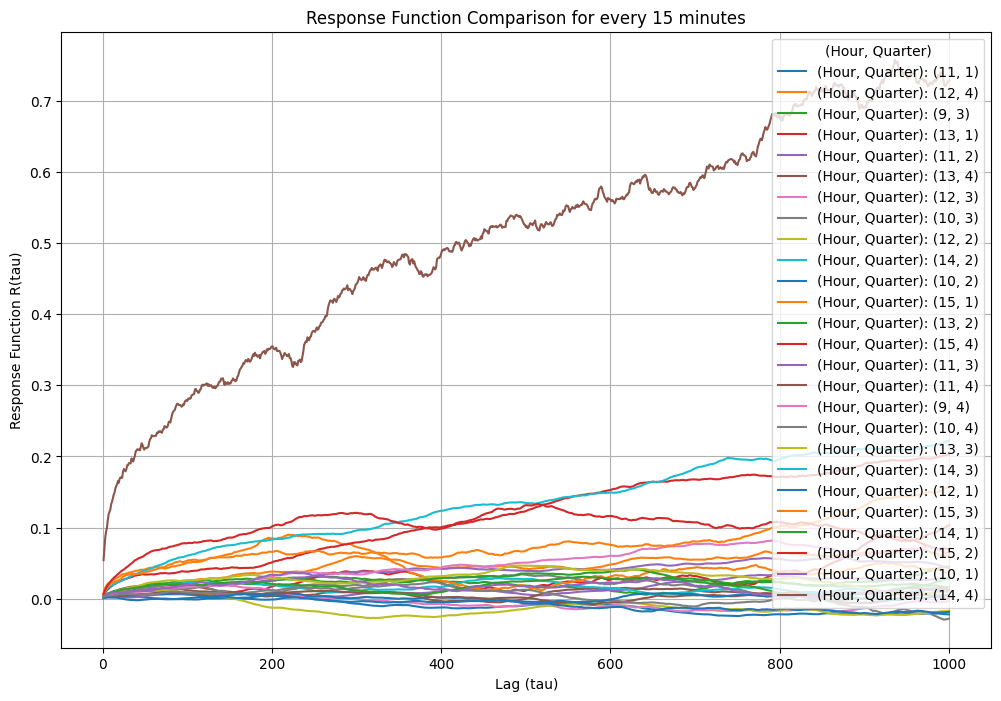

In [42]:
# The necessary functions to calculate the response function, fine-grained per hour and per 15 minutes, as well as functions to plot these response functions
# Are defined in falsh_crash_detection.py
from flash_crash_detection import *

# Using a tau_max of 1000 is enough to observe significant differences in the response functions, as well as limiting computation time
tau_max = 1000
df = add_hour_quarter(AAPL)
df_date = filter_by_date(df, "2010-05-06")
response_hourly = compute_hourly_response(df_date, tau_max)
response_quarterly = compute_minute_quarter_response(df_date, tau_max)
plot_hourly_responses(response_hourly, tau_max)
plot_quarterly_responses(response_quarterly, tau_max)

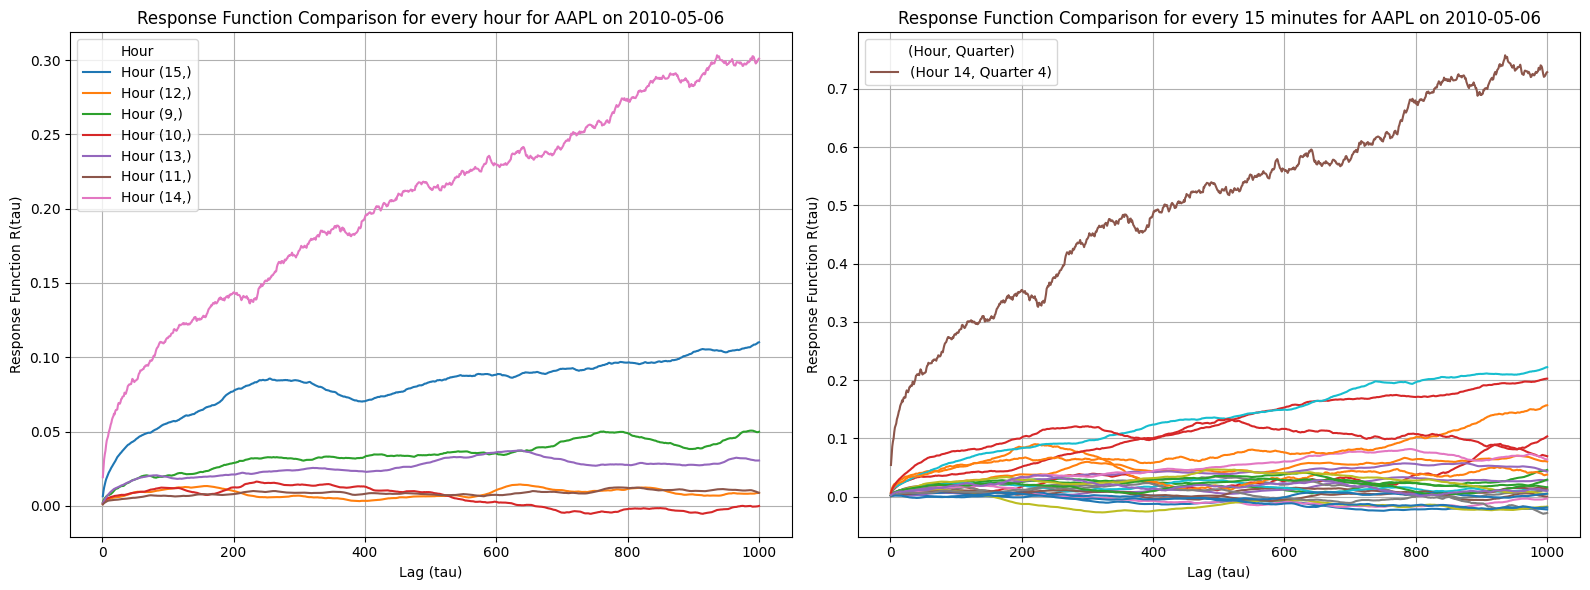

In [49]:
import matplotlib.pyplot as plt

def plot_hourly_and_quarterly_responses(hourly_responses: dict, quarterly_responses: dict, tau_max: int, save_path: str):
    """
    Plots the hourly and quarterly response functions side by side, with a filtered legend for the quarterly plot.

    Args:
        hourly_responses (dict): A dictionary where keys are hours and values are response arrays.
        quarterly_responses (dict): A dictionary where keys are (hour, quarter) tuples and values are response arrays.
        tau_max (int): Maximum lag (tau) for the x-axis.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Two subplots side by side

    # Plot hourly responses
    for hour, response in hourly_responses.items():
        tau_values = range(1, len(response) + 1)
        axes[0].plot(tau_values, response, label=f'Hour {hour}')
    axes[0].set_xlabel('Lag (tau)')
    axes[0].set_ylabel('Response Function R(tau)')
    axes[0].set_title('Response Function Comparison for every hour for AAPL on 2010-05-06')
    axes[0].legend(title="Hour")
    axes[0].grid()

    # Plot quarterly responses
    for (hour, quarter), response in quarterly_responses.items():
        tau_values = range(1, len(response) + 1)
        label = f'(Hour {hour}, Quarter {quarter})' if (hour, quarter) == (14, 4) else None
        axes[1].plot(tau_values, response, label=label)
    axes[1].set_xlabel('Lag (tau)')
    axes[1].set_ylabel('Response Function R(tau)')
    axes[1].set_title('Response Function Comparison for every 15 minutes for AAPL on 2010-05-06')
    if any((hour, quarter) == (14, 4) for hour, quarter in quarterly_responses.keys()):
        axes[1].legend(title="(Hour, Quarter)")
    axes[1].grid()

    # Adjust layout
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()




plot_hourly_and_quarterly_responses(response_hourly, response_quarterly, tau_max, "images_flash_crash/AAPL.png")

We can observe that the norm of the response function is a lot higher for Hour 14, Quarter 4, , corresponding to the period: 14:45-15:00. This corresponds to the timing of the flash crash in 2010, that started towards 14:32 for about 36 minutes on 05/06/2010.

##### Confirming with other stocks

We decide to work only with the assets where the flash crash can confidently be detected near or in the 14:45-15:00 interval. We consider that these stocks are guaranteed to have experienced extreme price movements during the flash crash. Restraining to these stocks will aslo allow for meaningful comparison when comparing the difference in asset clusters in high periods of volatility outside of the flash crash.


In [6]:
stocks_kept = []
stocks_not_kept = []

for file in os.listdir("processed/final_yearly/"):
    stock = pl.read_parquet("processed/final_yearly/" + file)
    stock = add_hour_quarter(stock)
    stock = filter_by_date(stock, "2010-05-06")
    response_hourly = compute_hourly_response(stock, tau_max)
    response_quarterly = compute_minute_quarter_response(stock, tau_max)

    # Use a generator to find the key and max absolute value
    max_key, max_value = max(
        ((key, np.max(np.abs(values))) for key, values in response_quarterly.items()),
        key=lambda x: x[1],  # Compare based on the absolute maximum value
    )

    # Check if the max key is either (14, 4) or (15, 1)
    if max_key in [(14,3), (14, 4), (15, 1)]:
        stocks_kept.append(file)  # Add the file name to stocks_kept
    else:
        stocks_not_kept.append(file)

    print(f"Max Absolute Value for {file}: {max_value} (Key: {max_key})")

Max Absolute Value for AAPL.OQ_combined.parquet: 0.7574399379133484 (Key: (14, 4))
Max Absolute Value for AMGN.OQ_combined.parquet: 0.027506402793946342 (Key: (14, 4))
Max Absolute Value for AXP.N_combined.parquet: 0.027586914062500044 (Key: (14, 4))
Max Absolute Value for BA.N_combined.parquet: 0.07102598091198328 (Key: (14, 4))
Max Absolute Value for CAT.N_combined.parquet: 0.03173760275788926 (Key: (15, 1))
Max Absolute Value for CSCO.OQ_combined.parquet: 0.01157296032221174 (Key: (14, 4))
Max Absolute Value for CVX.N_combined.parquet: 0.0458070985778535 (Key: (14, 4))
Max Absolute Value for DOW.N_combined.parquet: 0.01755320150659136 (Key: (14, 4))
Max Absolute Value for GS.N_combined.parquet: 0.04227120705381676 (Key: (9, 4))
Max Absolute Value for HD.N_combined.parquet: 0.013838037121790258 (Key: (14, 4))
Max Absolute Value for IBM.N_combined.parquet: 0.09959164292497641 (Key: (14, 3))
Max Absolute Value for INTC.OQ_combined.parquet: 0.005763102725366842 (Key: (14, 4))
Max Absolu

We decide to keep all assets that show their peak in response function in both 15 minute intervals adjacent to the 14:45 - 15:00 interval. We assume safely that a peak in the response function is also due to the flash crash.

In [7]:
# Keep only assets mentioned above
print(f"Keep {len(stocks_kept)} out of the original 29")

Keep 22 out of the original 29


In [61]:
stocks_kept

['AAPL.OQ_combined.parquet',
 'AMGN.OQ_combined.parquet',
 'AXP.N_combined.parquet',
 'BA.N_combined.parquet',
 'CAT.N_combined.parquet',
 'CSCO.OQ_combined.parquet',
 'CVX.N_combined.parquet',
 'DOW.N_combined.parquet',
 'HD.N_combined.parquet',
 'IBM.N_combined.parquet',
 'INTC.OQ_combined.parquet',
 'JPM.N_combined.parquet',
 'KO.N_combined.parquet',
 'MMM.N_combined.parquet',
 'MRK.N_combined.parquet',
 'PG.N_combined.parquet',
 'TRV.N_combined.parquet',
 'UTX.N_combined.parquet',
 'V.N_combined.parquet',
 'VZ.N_combined.parquet',
 'WMT.N_combined.parquet',
 'XOM.N_combined.parquet']

We are left with 22 stocks, removing the following for further analysis:

In [8]:
stocks_not_kept

['GS.N_combined.parquet',
 'JNJ.N_combined.parquet',
 'MCD.N_combined.parquet',
 'MSFT.OQ_combined.parquet',
 'NKE.N_combined.parquet',
 'PFE.N_combined.parquet',
 'UNH.N_combined.parquet']

A vizualisation allows to see that the response function profiles of these assets do not point towards a strong outlier during the flash crash. 

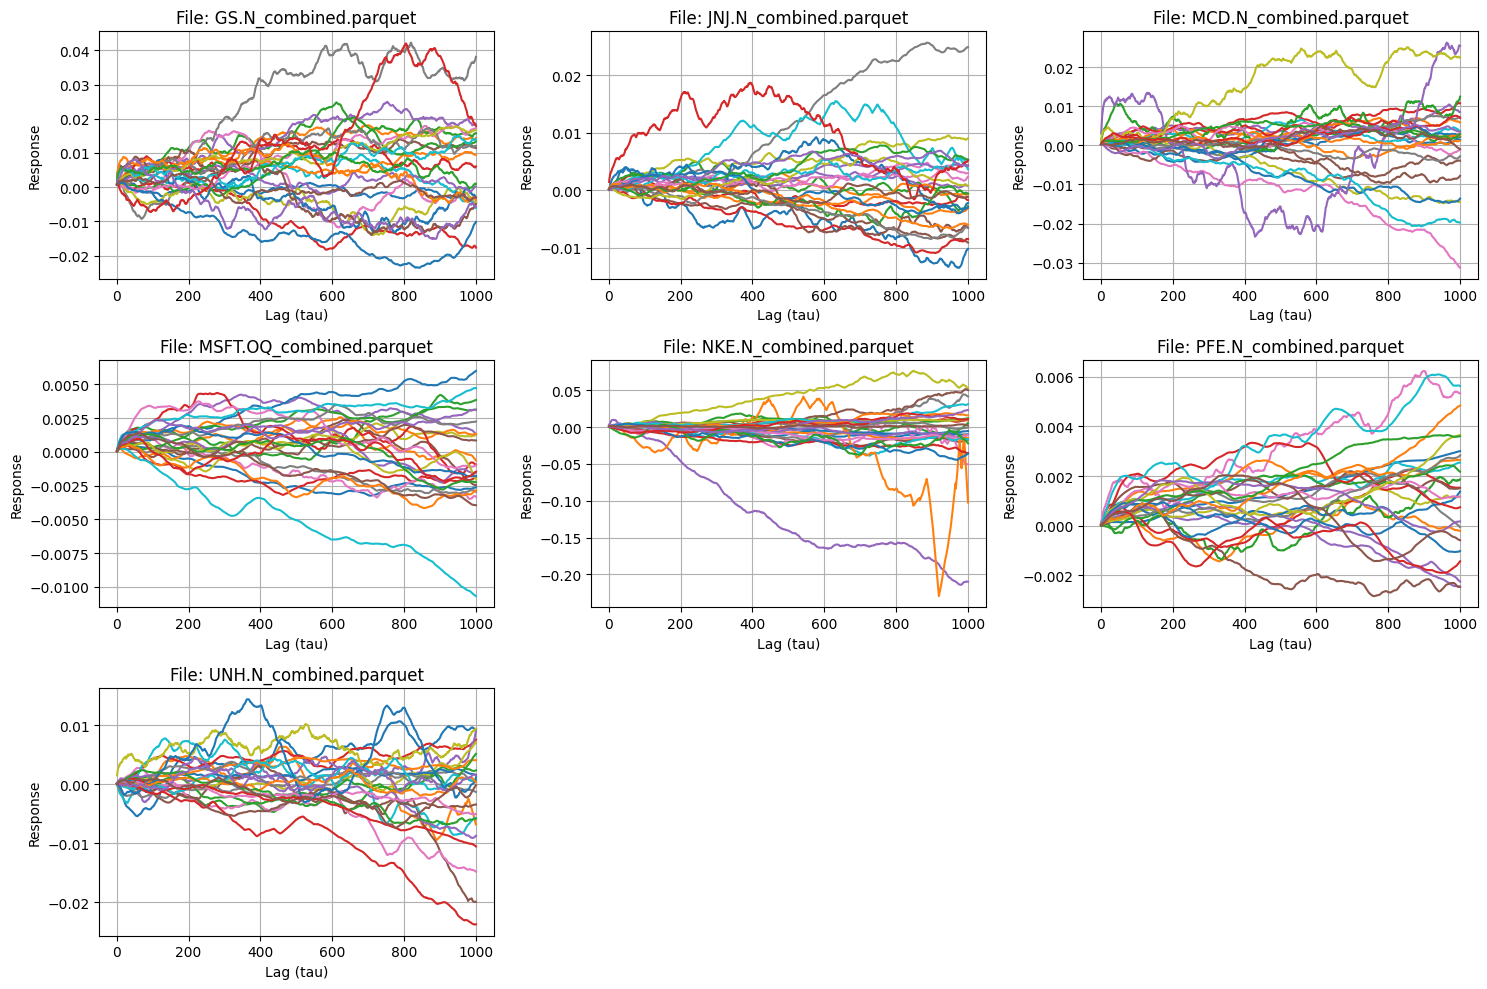

In [51]:
def plot_quarterly_responses_subplots(files, tau_max, save_path):
    """
    Plots the response functions for multiple files in subplots.

    Args:
        files (list): List of file names to process and plot.
        tau_max (int): Maximum lag (tau) for the x-axis.
    """
    # Calculate rows and columns for 7 subplots
    rows = 3
    cols = 3  # Set columns to 3 to fit in 3 rows

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

    # Flatten axes for easier indexing
    axes = axes.flatten()

    for idx, file in enumerate(files):
        if idx >= len(axes):
            break  # Stop if there are more files than subplots

        ax = axes[idx]
        stock = pl.read_parquet("processed/final_yearly/" + file)
        stock = add_hour_quarter(stock)
        stock = filter_by_date(stock, "2010-05-06")
        response_quarterly = compute_minute_quarter_response(stock, tau_max)

        # Plot responses for the current file
        for hour, response in response_quarterly.items():
            tau_values = range(1, len(response) + 1)
            ax.plot(tau_values, response, label=f'(Hour, Quarter): {hour}')

        # Add titles and labels
        ax.set_title(f"File: {file}")
        ax.set_xlabel("Lag (tau)")
        ax.set_ylabel("Response")
        ax.grid()

    # Hide unused subplots
    for ax in axes[len(files):]:
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_quarterly_responses_subplots(stocks_not_kept, tau_max, "images_flash_crash/removed_stocks.png")

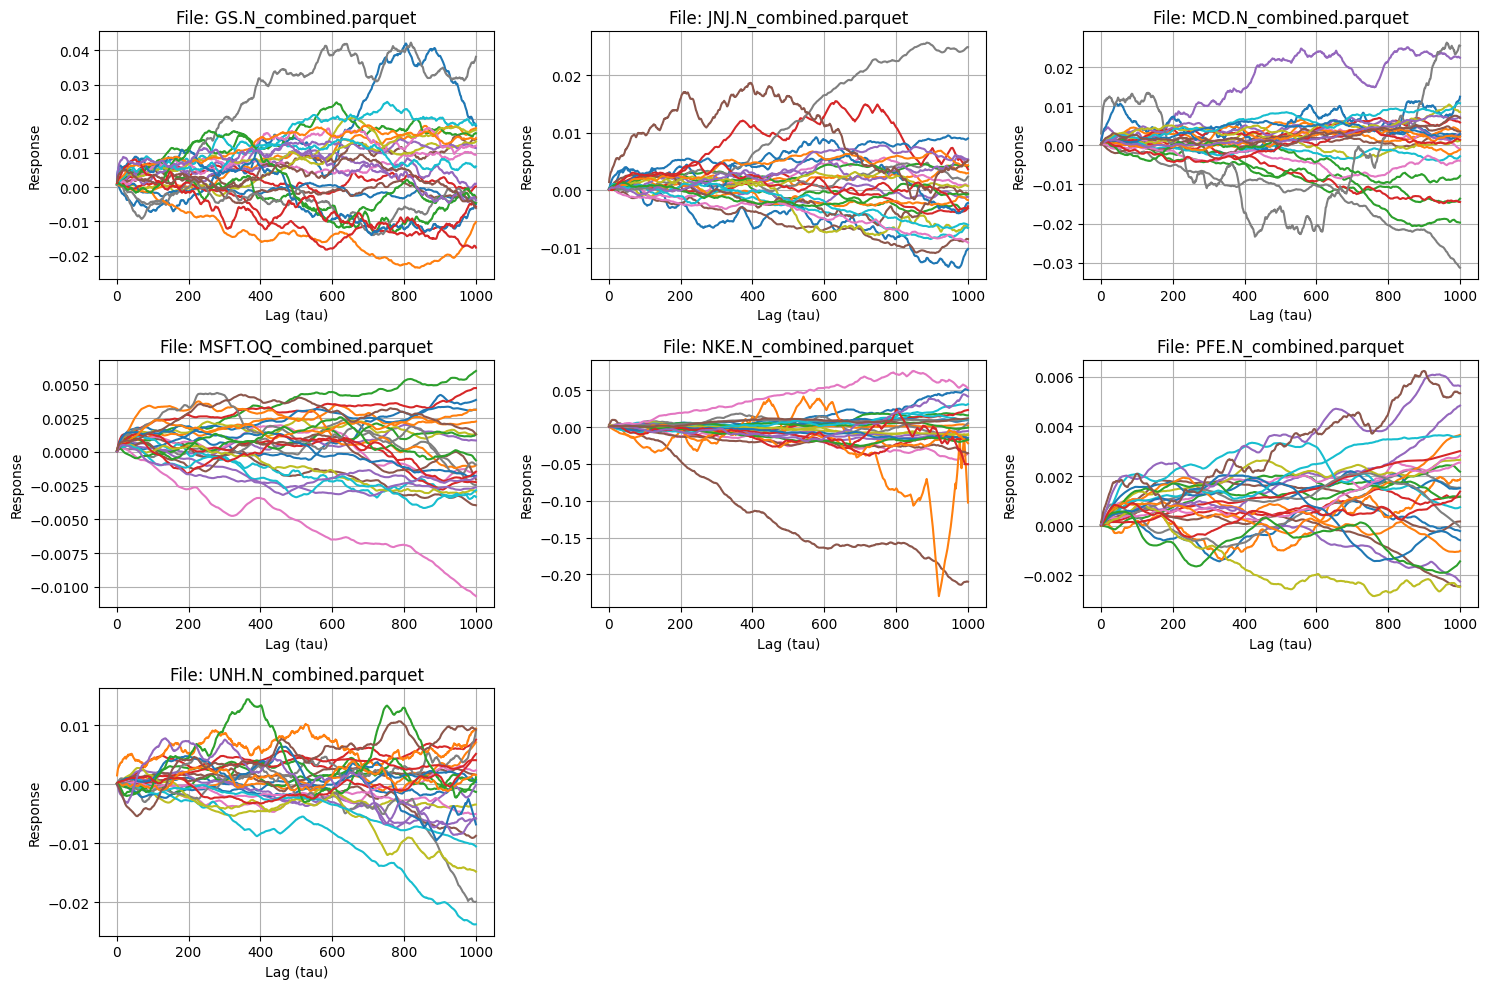

In [50]:
plot_quarterly_responses_subplots(stocks_not_kept, tau_max)

A closer look at the plot for MSFT shows that the outlier in response function norm is indeed not during the flash crash period.

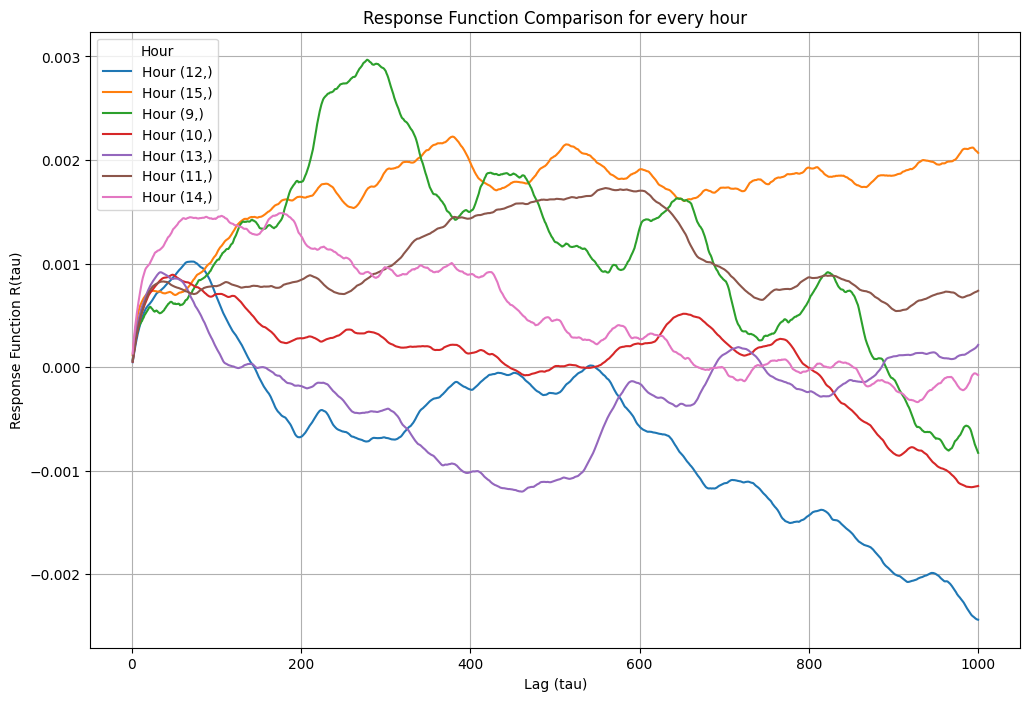

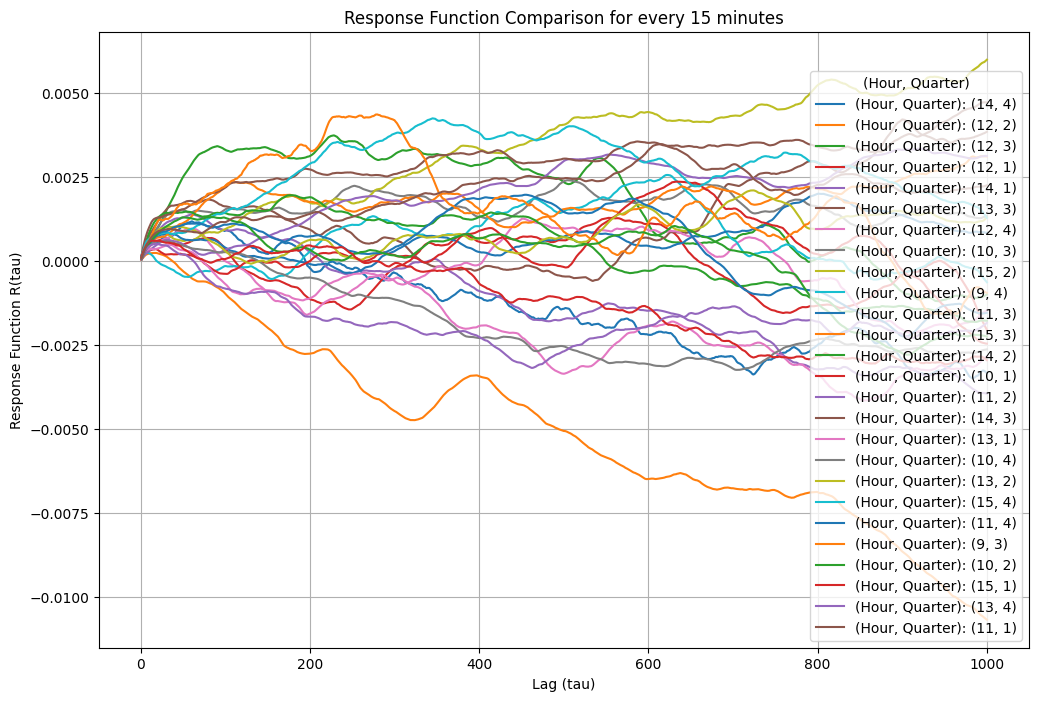

In [25]:
# Looking at MSFT, we can see highest peak hours before flash crash
MSFT = pl.read_parquet("processed/final_yearly/MSFT.OQ_combined.parquet")

tau_max = 1000
df = add_hour_quarter(MSFT)
df_date = filter_by_date(df, "2010-05-06")
response_hourly = compute_hourly_response(df_date, tau_max)
response_quarterly = compute_minute_quarter_response(df_date, tau_max)
plot_hourly_responses(response_hourly, tau_max)
plot_quarterly_responses(response_quarterly, tau_max)

For the case of NKE, we see that the response function profile does show a higher norm for the moment of the flash crash, although it also shows a higher peak for the period 12:00-12:15. We decide not to keep this asset to stay on the safe side, also considering that 22 assets will be enough for significant further analysis.

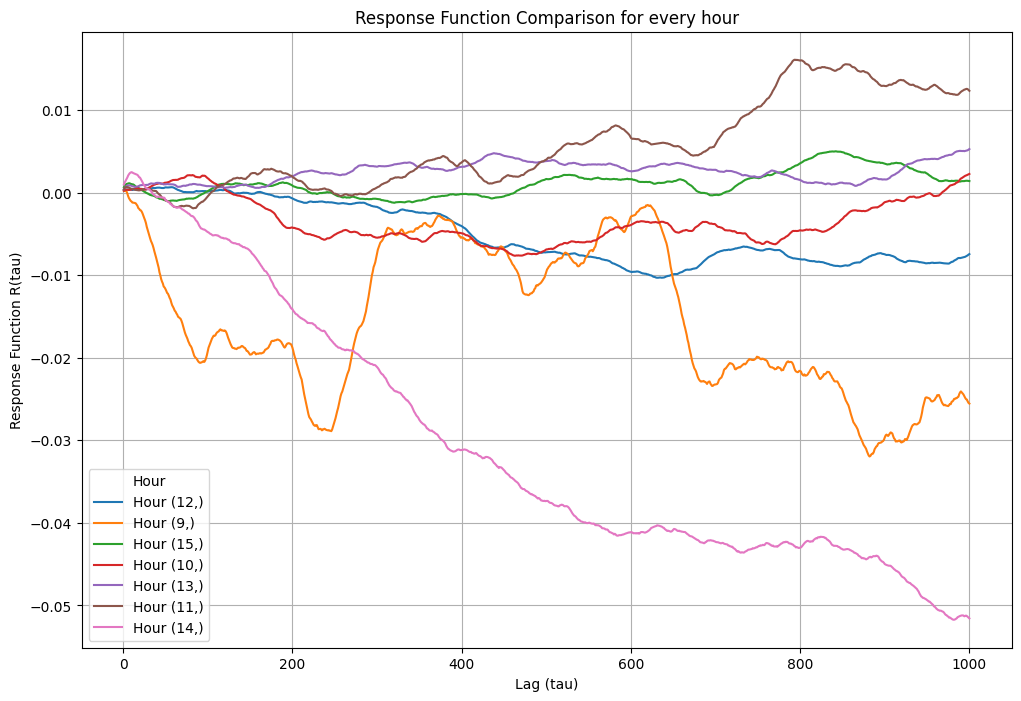

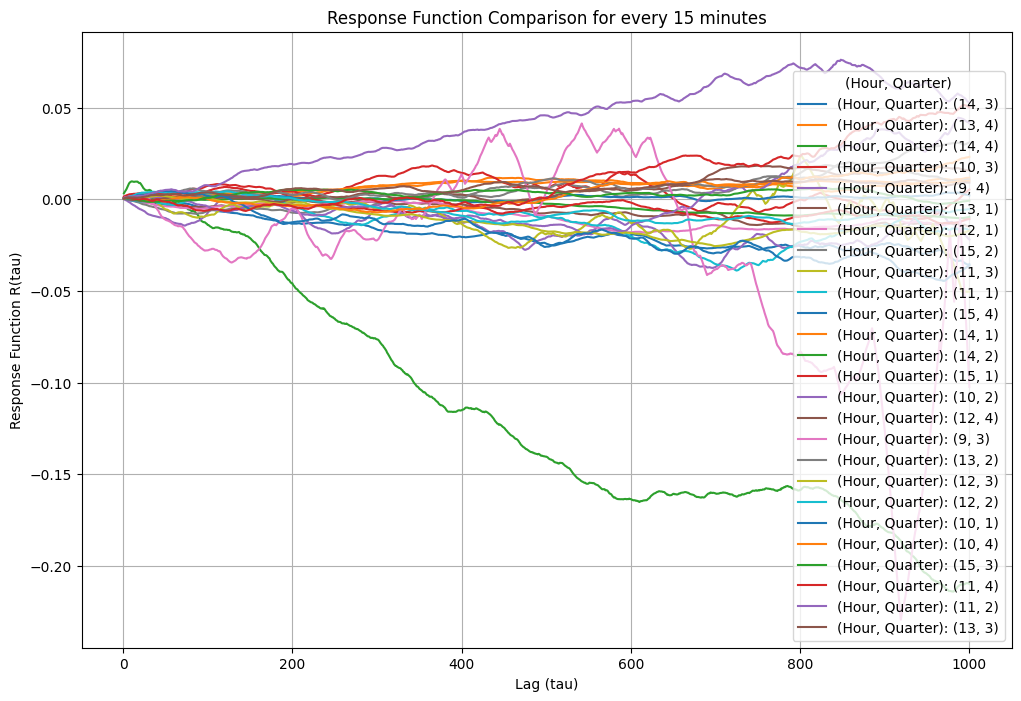

In [26]:
# Looking at NKE, we can see highest peak hours before flash crash
MSFT = pl.read_parquet("processed/final_yearly/NKE.N_combined.parquet")

tau_max = 1000
df = add_hour_quarter(MSFT)
df_date = filter_by_date(df, "2010-05-06")
response_hourly = compute_hourly_response(df_date, tau_max)
response_quarterly = compute_minute_quarter_response(df_date, tau_max)
plot_hourly_responses(response_hourly, tau_max)
plot_quarterly_responses(response_quarterly, tau_max)

#### Searching for other periods where the response function of assets experience simultaneous peaks.

Continuing on those 22 assets, we can see that even though they all experience high peak in response function during flash crash, the norms of those peaks have different orders of magnitude. We decide to construct a portfolio, where each asset is weighted with the inverse of the sum of the median of observed response function values per 15 minute intervals, over a chosen period of time. We then also normalize the weights to have sum of weights equal to one. Allowing for each stock to have equal impact on the portfolio, making this a relevant porfolio for observing simultaneous peaks of response function of mutiple assets. 

We then obtain the periods where the response function shows highest norm for the constructed portfolio, over the same period of time that was used to construct said porfolio.

#### Sanity check: We run this method on the month of May to show that the peak is indeed during the flash crash.

In [56]:
def add_month(df):
    return df.with_columns(
        df["date"].str.slice(5, 2).alias("month")  # Extract characters 5–7 from the 'date' column
    )

def compute_impact_equal_portfolio(file_paths, tau_max, months):
    """
    Compute portfolio weights where each stock has the same impact.

    Args:
        file_paths (list): List of file paths for the 22 assets.
        tau_max (int): Maximum lag (tau) for the response function.
        month (str): Month to sample (default: "03" for March).

    Returns:
        dict: Asset weights for an impact-equal portfolio.
    """
    inverse_peaks = {}

    # Step 1: Compute total response peaks for each asset
    for file in file_paths:
        df = pl.read_parquet('processed/final_yearly/' + file)
        df = add_month(df)
        df = df.filter(df["month"].is_in(months))  # Filter for rows where month is in the list
        df = add_hour_quarter(df)
        df = df.drop_nulls()  # Remove rows with NaN values


        # Compute response function
        response_quarterly = compute_minute_quarter_response(df, tau_max)

        # Calculate total response peak for this asset
        total_peak = np.sum([np.median(np.abs(values)) for values in response_quarterly.values()])

        # Store the inverse of the total peak
        inverse_peaks[file] = 1 / total_peak if total_peak > 0 else 0
        print(inverse_peaks[file])

    # Step 2: Normalize weights to sum to 1
    total_inverse = sum(inverse_peaks.values())
    portfolio_weights = {asset: inverse / total_inverse for asset, inverse in inverse_peaks.items()}

    return portfolio_weights

# Example usage
# Stocks kept corresponds to 22 stocks we decided to keep
file_paths = stocks_kept
tau_max = 1000
portfolio_weights = compute_impact_equal_portfolio(file_paths, tau_max, months=["05"])

# Display the portfolio weights
for asset, weight in portfolio_weights.items():
    print(f"{asset}: {weight:.4f}")

1.6369664661509549
6.828215910487466
11.465250845960748
3.7528273366327185
6.41277751450162
12.982038182214556
8.542666228958991
9.19743666709848
12.158845030292362
4.524835682019647
16.897174157566173
16.452293922917594
11.02967497032642
5.01215726466322
11.36820117333065
16.564326114484416
7.818614135980393
7.1851411415615924
3.0679567422950926
16.644234865667162
12.079910999864637
17.046718634795983
AAPL.OQ_combined.parquet: 0.0075
AMGN.OQ_combined.parquet: 0.0312
AXP.N_combined.parquet: 0.0524
BA.N_combined.parquet: 0.0172
CAT.N_combined.parquet: 0.0293
CSCO.OQ_combined.parquet: 0.0594
CVX.N_combined.parquet: 0.0391
DOW.N_combined.parquet: 0.0421
HD.N_combined.parquet: 0.0556
IBM.N_combined.parquet: 0.0207
INTC.OQ_combined.parquet: 0.0773
JPM.N_combined.parquet: 0.0752
KO.N_combined.parquet: 0.0504
MMM.N_combined.parquet: 0.0229
MRK.N_combined.parquet: 0.0520
PG.N_combined.parquet: 0.0758
TRV.N_combined.parquet: 0.0358
UTX.N_combined.parquet: 0.0329
V.N_combined.parquet: 0.0140
VZ.

In [57]:
def get_portfolio_response_peaks(file_paths, portfolio_weights, tau_max, months, threshold_percentile=70):
    """
    Get response function peaks distribution for the portfolio and identify high-peak dates and hours.

    Args:
        file_paths (list): List of file paths for the assets.
        portfolio_weights (dict): Portfolio weights for each asset.
        tau_max (int): Maximum lag (tau) for the response function.
        months (list): List of months to consider (e.g., ["03"] for March).
        threshold_percentile (int): Percentile to define "high" peaks (default: 95).

    Returns:
        dict: Dates and hours with high response function peaks for the portfolio.
    """
    # Initialize aggregated response function
    portfolio_response = {}

    for file in file_paths:

        # Load and preprocess data
        df = pl.read_parquet('processed/final_yearly/' + file)
        df = add_month(df)
        df = df.filter(df["month"].is_in(months))
        df = add_hour_quarter(df)
        df = df.drop_nulls()

        for date in df["date"].unique().sort():
            # Compute response function
            date_df = df.filter(df["date"] == date)  # Filter rows for the current date
            response_quarterly = compute_minute_quarter_response(date_df, tau_max)
            for (hour, quarter), values in response_quarterly.items():
                response_peak = np.median(np.abs(values))
                key = (date, hour, quarter)
                if key not in portfolio_response:
                    portfolio_response[key] = 0
                portfolio_response[key] += response_peak * portfolio_weights[file]
            print(f'finished for date {date}')
        print(f'finished for file {file}')

    # Determine threshold for high peaks
    all_peaks = np.array(list(portfolio_response.values()))
    high_peak_threshold = np.percentile(all_peaks, threshold_percentile)

    # Identify dates and hours with high peaks
    high_peaks = {
        key: value
        for key, value in portfolio_response.items()
        if value >= high_peak_threshold
    }

    return {"high_peaks": high_peaks, "threshold": high_peak_threshold}

# Example Usage
file_paths = stocks_kept
portfolio_weights = portfolio_weights
tau_max = 1000
months = ["05"]

results = get_portfolio_response_peaks(file_paths, portfolio_weights, tau_max, months)

# Display results
print("High Response Peaks (Date, Hour):")
for key, value in results["high_peaks"].items():
    print(f"{key}: {value:.4f}")

print(f"Threshold for High Peaks: {results['threshold']:.4f}")

finished for date 2010-05-03
finished for date 2010-05-04
finished for date 2010-05-05
finished for date 2010-05-06
finished for date 2010-05-07
finished for date 2010-05-10
finished for date 2010-05-11
finished for date 2010-05-12
finished for date 2010-05-13
finished for date 2010-05-14
finished for date 2010-05-17
finished for date 2010-05-18
finished for date 2010-05-19
finished for date 2010-05-20
finished for date 2010-05-21
finished for date 2010-05-24
finished for date 2010-05-25
finished for date 2010-05-26
finished for date 2010-05-28
finished for file AAPL.OQ_combined.parquet
finished for date 2010-05-03
finished for date 2010-05-04
finished for date 2010-05-05
finished for date 2010-05-06
finished for date 2010-05-07
finished for date 2010-05-10
finished for date 2010-05-11
finished for date 2010-05-12
finished for date 2010-05-13
finished for date 2010-05-14
finished for date 2010-05-17
finished for date 2010-05-18
finished for date 2010-05-19
finished for date 2010-05-20


In [58]:
# Assuming results['high_peaks'] is a dictionary
highest_key, highest_value = max(results['high_peaks'].items(), key=lambda x: x[1])

# Print the results
print(f"Highest value: {highest_value:.4f}, Key: {highest_key}")

Highest value: 0.0414, Key: ('2010-05-06', 14, 4)


We find that indeed the highest peak for the median of the response function is observed during the flash crash, on the 2010-05-06, between 14:45-15:00. With a significant peak during this period. We also plot a distribution of the top 30% of values obtained for each period for the constructed portfolio.

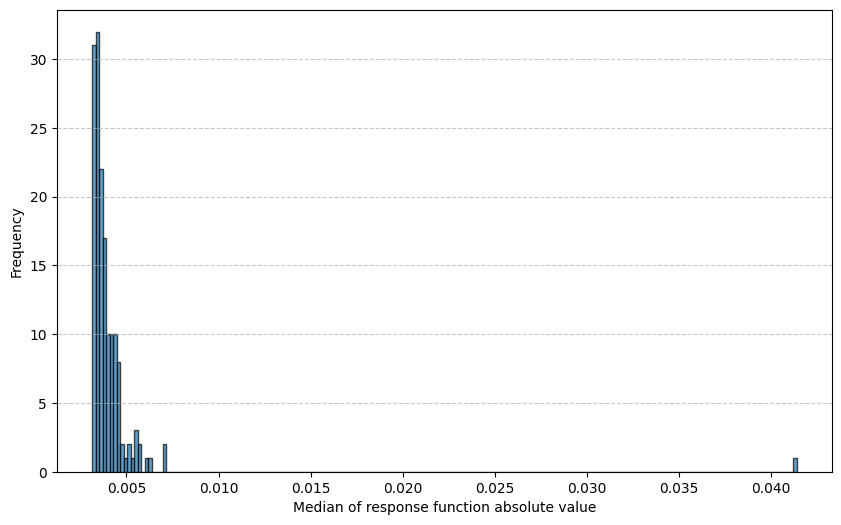

In [60]:
# Extract values from the dictionary
values = list(results['high_peaks'].values())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(values, bins=200, edgecolor='black', alpha=0.7)  # Adjust bins as needed
plt.xlabel('Median of response function absolute value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('images_flash_crash/outlier.png', dpi=300, bbox_inches='tight')
plt.show()

The histogram clearly shows the impact of the flash crash, where the value is 400% higher than for any other period.

#### Following sanity check, we use the constructed portfolio over every month of the year to obtain periods where it experiences highest median value of its response function.

Note: this script takes about an hour to run

In [14]:
from flash_crash_detection import *
# Get the inverse weigths portfolio from the same months where you search for high peaks
# We run the script for every remaining month in 2010

track_dict = {}

months = ["01", "02", "03", "04", "06", "07", "08", "09", "10", "11", "12"]
for month in months:
    # Use a single-item list for the current month
    current_month = [month]
    print(f"Processing month: {current_month}")  # Debug output
    
    results = get_high_peak_dates_portfolio(stocks_kept, 1000, months=current_month)

    # Get top value for May 2010
    # Sort the dictionary by values in descending order
    sorted_high_peaks = sorted(results['high_peaks'].items(), key=lambda x: x[1], reverse=True)
    
    track_dict[month] = sorted_high_peaks

    # Get the highest values (e.g., top 5)
    top_n = 10  # Adjust this number as needed
    highest_values = sorted_high_peaks[:top_n]

    # Print the highest values
    print(f"Top 10 High Peaks for {current_month}:")
    for key, value in highest_values:
        print(f"{key}: {value:.4f}")

Processing month: ['01']
Top 10 High Peaks for ['01']:
('2010-01-19', 9, 3): 0.0090
('2010-01-13', 9, 3): 0.0080
('2010-01-27', 9, 3): 0.0079
('2010-01-27', 14, 1): 0.0077
('2010-01-28', 9, 3): 0.0074
('2010-01-14', 12, 1): 0.0073
('2010-01-25', 9, 3): 0.0071
('2010-01-14', 9, 3): 0.0070
('2010-01-19', 12, 1): 0.0067
('2010-01-11', 9, 3): 0.0065
Processing month: ['02']
Top 10 High Peaks for ['02']:
('2010-02-08', 9, 3): 0.0078
('2010-02-03', 13, 1): 0.0078
('2010-02-19', 10, 2): 0.0073
('2010-02-01', 9, 4): 0.0068
('2010-02-18', 9, 3): 0.0068
('2010-02-22', 9, 3): 0.0063
('2010-02-01', 9, 3): 0.0063
('2010-02-03', 12, 3): 0.0062
('2010-02-26', 13, 2): 0.0061
('2010-02-22', 13, 3): 0.0061
Processing month: ['03']
Top 10 High Peaks for ['03']:
('2010-03-08', 12, 3): 0.0074
('2010-03-12', 9, 3): 0.0061
('2010-03-11', 15, 1): 0.0059
('2010-03-31', 12, 3): 0.0055
('2010-03-11', 13, 1): 0.0054
('2010-03-04', 12, 3): 0.0053
('2010-03-11', 12, 1): 0.0053
('2010-03-22', 9, 3): 0.0052
('2010-03

In [62]:
track_dict

{'01': [(('2010-01-19', 9, 3), np.float64(0.009039409254509672)),
  (('2010-01-13', 9, 3), np.float64(0.0079784367064959)),
  (('2010-01-27', 9, 3), np.float64(0.007868262335482039)),
  (('2010-01-27', 14, 1), np.float64(0.007659305006668434)),
  (('2010-01-28', 9, 3), np.float64(0.00743981862309368)),
  (('2010-01-14', 12, 1), np.float64(0.007322363510608707)),
  (('2010-01-25', 9, 3), np.float64(0.007090918496600328)),
  (('2010-01-14', 9, 3), np.float64(0.007048948471219946)),
  (('2010-01-19', 12, 1), np.float64(0.0067414351634498965)),
  (('2010-01-11', 9, 3), np.float64(0.006529337399767714)),
  (('2010-01-14', 11, 2), np.float64(0.006416919798214136)),
  (('2010-01-22', 9, 3), np.float64(0.00636892821260199)),
  (('2010-01-13', 11, 2), np.float64(0.006358793094544257)),
  (('2010-01-08', 13, 1), np.float64(0.00628826393772341)),
  (('2010-01-05', 13, 2), np.float64(0.006273946500581754)),
  (('2010-01-11', 12, 1), np.float64(0.006181883447857169)),
  (('2010-01-11', 13, 3), np.f

In [64]:
exclude_values = (9, 3)

# Extract the highest values for each key excluding specific values
filtered_highest_values = {}
for key, value_list in track_dict.items():
    # Filter out tuples containing the excluded values
    filtered_list = [item for item in value_list if item[0][1:] != exclude_values]
    
    # Find the maximum if filtered_list is not empty
    if filtered_list:
        filtered_highest_values[key] = max(filtered_list, key=lambda x: x[1])

print(filtered_highest_values)

{'01': (('2010-01-27', 14, 1), np.float64(0.007659305006668434)), '02': (('2010-02-03', 13, 1), np.float64(0.007757700632003978)), '03': (('2010-03-08', 12, 3), np.float64(0.00741922050173793)), '04': (('2010-04-05', 10, 1), np.float64(0.011184831643188292)), '06': (('2010-06-11', 13, 2), np.float64(0.006737400254803028)), '07': (('2010-07-23', 12, 4), np.float64(0.006229297377599405)), '08': (('2010-08-20', 12, 4), np.float64(0.007261468189877027)), '09': (('2010-09-23', 14, 3), np.float64(0.007715036557408415)), '10': (('2010-10-28', 13, 1), np.float64(0.007419266330713952)), '11': (('2010-11-26', 13, 2), np.float64(0.011852418876322157)), '12': (('2010-12-31', 12, 1), np.float64(0.006588530615471078))}


We obtain the following dates and periods of interest: 

 - Top 10 High Peaks for ['01']:
('2010-01-19', 9, 3): 0.0090
('2010-01-13', 9, 3): 0.0080
('2010-01-27', 9, 3): 0.0079
('2010-01-27', 14, 1): 0.0077
('2010-01-28', 9, 3): 0.0074
('2010-01-14', 12, 1): 0.0073
('2010-01-25', 9, 3): 0.0071
('2010-01-14', 9, 3): 0.0070
('2010-01-19', 12, 1): 0.0067
('2010-01-11', 9, 3): 0.0065
 - Top 10 High Peaks for ['02']:
('2010-02-08', 9, 3): 0.0078
('2010-02-03', 13, 1): 0.0078
('2010-02-19', 10, 2): 0.0073
('2010-02-01', 9, 4): 0.0068
('2010-02-18', 9, 3): 0.0068
('2010-02-22', 9, 3): 0.0063
('2010-02-01', 9, 3): 0.0063
('2010-02-03', 12, 3): 0.0062
('2010-02-26', 13, 2): 0.0061
('2010-02-22', 13, 3): 0.0061
 - Top 10 High Peaks for ['03']:
('2010-03-08', 12, 3): 0.0074
('2010-03-12', 9, 3): 0.0061
('2010-03-11', 15, 1): 0.0059
('2010-03-31', 12, 3): 0.0055
('2010-03-11', 13, 1): 0.0054
('2010-03-04', 12, 3): 0.0053
('2010-03-11', 12, 1): 0.0053
('2010-03-22', 9, 3): 0.0052
('2010-03-19', 13, 3): 0.0052
('2010-03-17', 9, 4): 0.0052
 - Top 10 High Peaks for ['04']:
('2010-04-05', 10, 1): 0.0112
('2010-04-09', 13, 4): 0.0081
('2010-04-05', 9, 3): 0.0076
('2010-04-05', 13, 2): 0.0072
('2010-04-23', 9, 3): 0.0069
('2010-04-30', 12, 4): 0.0068
('2010-04-20', 14, 1): 0.0064
('2010-04-26', 9, 3): 0.0064
('2010-04-06', 12, 4): 0.0063
('2010-04-05', 13, 4): 0.0062
 - Top 10 High Peaks for ['06']:
('2010-06-11', 13, 2): 0.0067
('2010-06-23', 12, 2): 0.0059
('2010-06-10', 9, 3): 0.0059
('2010-06-15', 9, 3): 0.0056
('2010-06-04', 12, 4): 0.0055
('2010-06-22', 9, 3): 0.0055
('2010-06-24', 9, 3): 0.0053
('2010-06-16', 12, 2): 0.0053
('2010-06-11', 11, 4): 0.0051
('2010-06-11', 13, 1): 0.0051
 - Top 10 High Peaks for ['07']:
('2010-07-23', 9, 3): 0.0080
('2010-07-16', 9, 3): 0.0079
('2010-07-21', 9, 3): 0.0070
('2010-07-23', 12, 4): 0.0062
('2010-07-22', 9, 3): 0.0062
('2010-07-26', 9, 3): 0.0061
('2010-07-19', 9, 3): 0.0059
('2010-07-07', 9, 3): 0.0058
('2010-07-12', 12, 3): 0.0057
('2010-07-22', 12, 4): 0.0056
 - Top 10 High Peaks for ['08']:
('2010-08-23', 9, 3): 0.0087
('2010-08-09', 9, 3): 0.0080
('2010-08-20', 12, 4): 0.0073
('2010-08-10', 13, 3): 0.0072
('2010-08-17', 9, 3): 0.0072
('2010-08-17', 12, 3): 0.0070
('2010-08-03', 9, 3): 0.0069
('2010-08-18', 9, 3): 0.0067
('2010-08-06', 9, 3): 0.0065
('2010-08-05', 9, 3): 0.0064
 - Top 10 High Peaks for ['09']:
('2010-09-22', 9, 3): 0.0097
('2010-09-29', 9, 3): 0.0093
('2010-09-23', 9, 3): 0.0091
('2010-09-27', 9, 3): 0.0088
('2010-09-28', 9, 3): 0.0083
('2010-09-08', 9, 3): 0.0081
('2010-09-23', 14, 3): 0.0077
('2010-09-07', 9, 3): 0.0076
('2010-09-13', 9, 3): 0.0076
('2010-09-28', 13, 1): 0.0072
 - Top 10 High Peaks for ['10']:
('2010-10-01', 9, 3): 0.0087
('2010-10-21', 9, 3): 0.0085
('2010-10-28', 13, 1): 0.0074
('2010-10-28', 9, 3): 0.0073
('2010-10-06', 9, 3): 0.0073
('2010-10-04', 9, 3): 0.0070
('2010-10-29', 9, 3): 0.0070
('2010-10-28', 12, 3): 0.0067
('2010-10-20', 12, 3): 0.0066
('2010-10-25', 12, 2): 0.0065
 - Top 10 High Peaks for ['11']:
('2010-11-26', 13, 2): 0.0119
('2010-11-15', 9, 3): 0.0096
('2010-11-26', 14, 3): 0.0094
('2010-11-11', 9, 3): 0.0090
('2010-11-22', 9, 3): 0.0090
('2010-11-09', 11, 4): 0.0086
('2010-11-26', 13, 1): 0.0084
('2010-11-19', 11, 4): 0.0077
('2010-11-01', 9, 3): 0.0076
('2010-11-04', 12, 4): 0.0073
 - Top 10 High Peaks for ['12']:
('2010-12-27', 9, 3): 0.0080
('2010-12-28', 9, 3): 0.0079
('2010-12-14', 9, 3): 0.0074
('2010-12-29', 9, 3): 0.0071
('2010-12-31', 12, 1): 0.0066
('2010-12-31', 10, 2): 0.0063
('2010-12-29', 11, 1): 0.0062
('2010-12-21', 9, 3): 0.0062
('2010-12-30', 9, 3): 0.0061
('2010-12-21', 11, 4): 0.0061


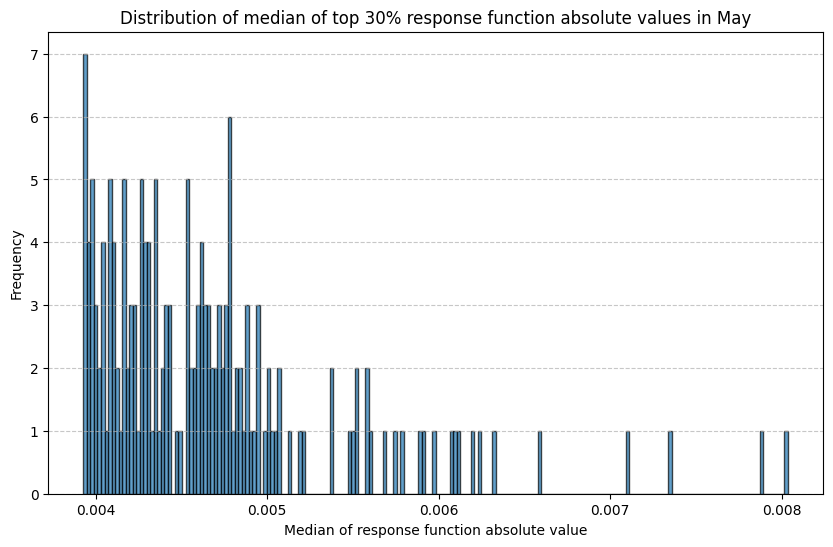

In [31]:
values = [item[1] for item in track_dict['12']]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(values, bins=200, edgecolor='black', alpha=0.7)  # Adjust bins as needed
plt.xlabel('Median of response function absolute value')
plt.ylabel('Frequency')
plt.title('Distribution of median of top 30% response function absolute values in May')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

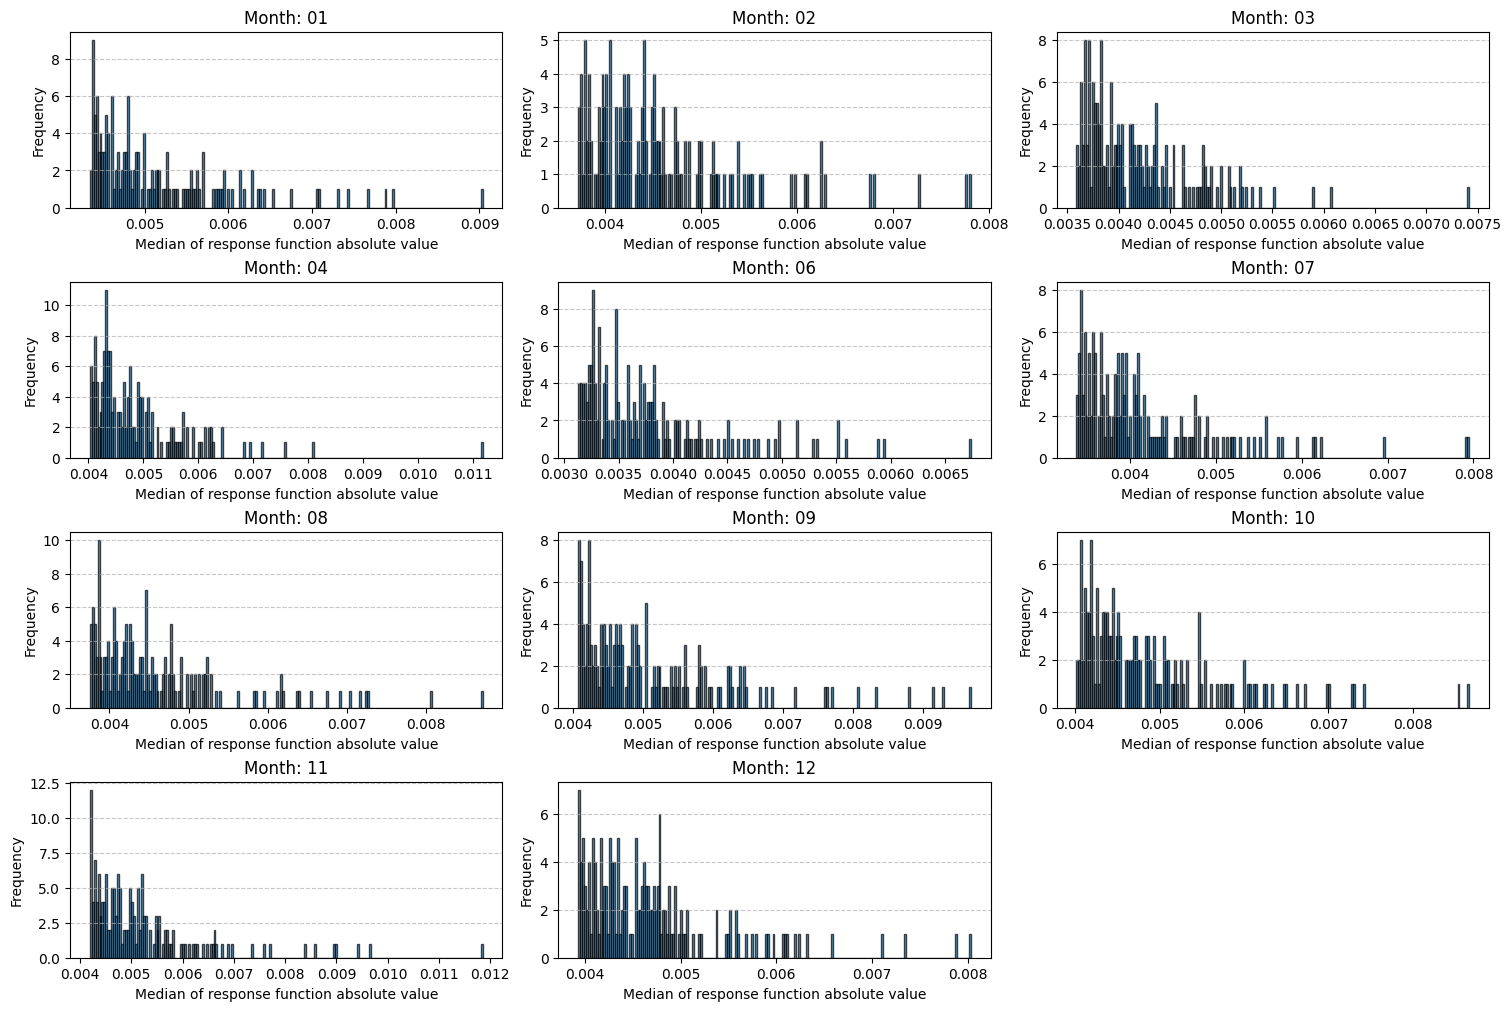

In [55]:
import matplotlib.pyplot as plt

# Define the months you want to plot
months = ["01", "02", "03", "04", "06", "07", "08", "09", "10", "11", "12"]

# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easier indexing

# Loop through months and plot histograms
for idx, month in enumerate(months):
    values = [item[1] for item in track_dict[month]]  # Extract values for the month
    ax = axes[idx]
    
    # Plot the histogram
    ax.hist(values, bins=200, edgecolor='black', alpha=0.7)  # Adjust bins as needed
    ax.set_title(f"Month: {month}")
    ax.set_xlabel('Median of response function absolute value')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove extra subplot spaces if months < total subplots
if len(months) < len(axes):
    for ax in axes[len(months):]:
        ax.remove()

# Display the plots
plt.savefig('images_flash_crash/monthly_response_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


We use the distribution of median of top 30% response function absolute values for the top 15 minute interval of every month.

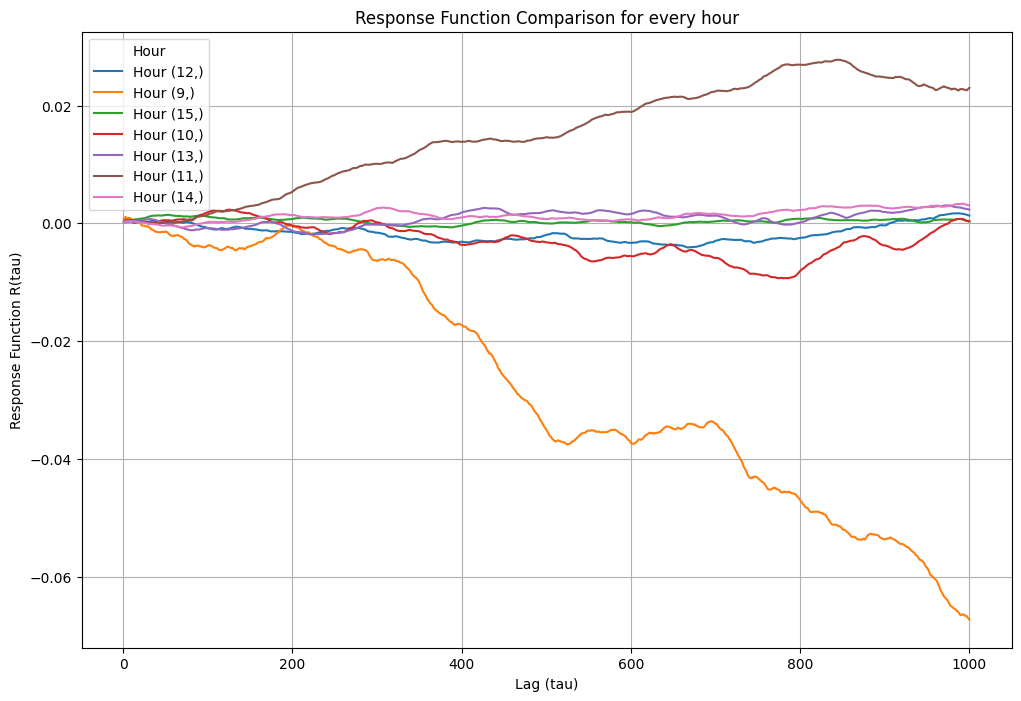

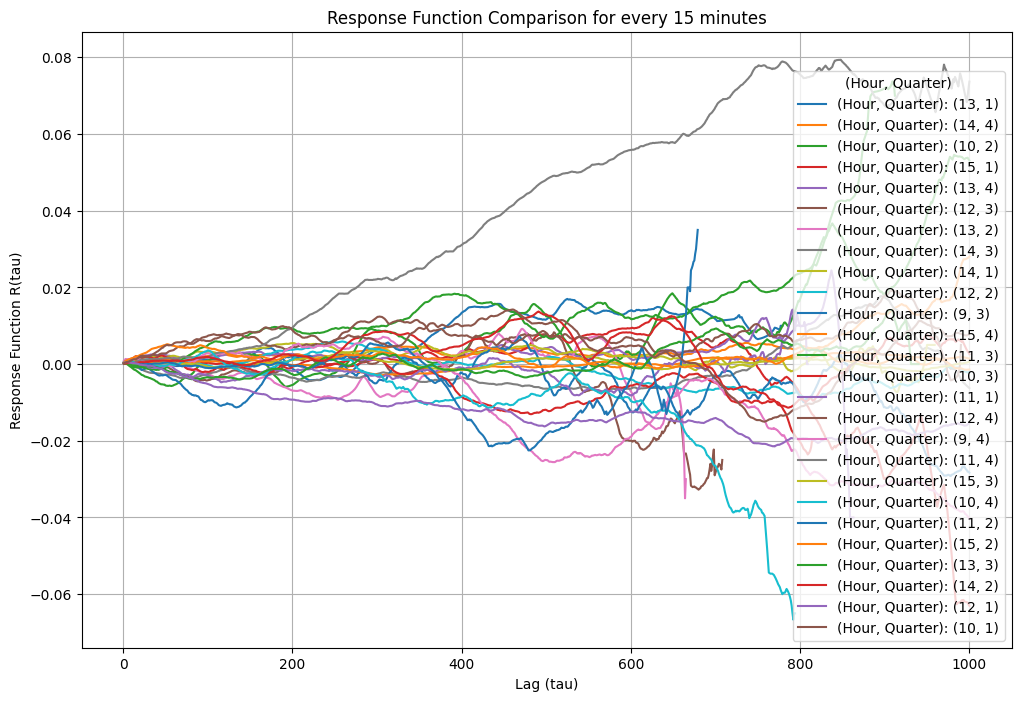

In [32]:
AAPL = pl.read_parquet("processed/final_yearly/BA.N_combined.parquet")
# Using a tau_max of 1000 is enough to observe significant differences in the response functions, as well as limiting computation time
tau_max = 1000
df = add_hour_quarter(AAPL)
df_date = filter_by_date(df, "2010-01-19")
response_hourly = compute_hourly_response(df_date, tau_max)
response_quarterly = compute_minute_quarter_response(df_date, tau_max)
plot_hourly_responses(response_hourly, tau_max)
plot_quarterly_responses(response_quarterly, tau_max)

We decide to work with these periods for the next steps of asset clustering.